# River Basin Equilibrium Water Supply Toy Model - Visualization

In [1]:
import river_basin_equilibrium_g43compat as rbe
import numpy as np
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from matplotlib import ticker
gams_dir = r'C:\Users\nboyd\OneDrive\Documents\Academic\UMD - ME PhD\Research\Python'

##  Data Definition

In [2]:
#Sets 
players = ['1','2','3'] #River users
classes = ['1','2'] #Consumptive use classes
time_periods = ['1','2'] #Time periods
V = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15']
#Scalars
prd = 5 #Period of time unit
cyc = 2 #Cycles in planning period
ir = 0.04 #Interest rate
beta = 3 #Inverse demand slope
#Parameters
srt_pts = {'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0,'10':0,'11':0,'12':0,'13':0,'14':0,'15':0}
n = {'1':9,'2':0,'3':0} #Inflow at node i
rfc = {'1':4,'2':4,'3':4} #Flow constraint at node i
c_ops = {'1':1,'2':1,'3':1} #Operating cost for node i
c_sr = {'1':0,'2':0,'3':0} #Storage cost for node i
c_cap = {'1':0,'2':0,'3':0} #Capital costs for each player
#Table: Consumptive Use Classes for player i in class c
c_cu = {('1','1'):2/3, ('1','2'):10/3,
        ('2','1'):1, ('2','2'):5,
        ('3','1'):1, ('3','2'):5
        }
a_req = {('1','1'):0,('1','2'):0,
         ('2','1'):0,('2','2'):0,
         ('3','1'):0,('3','2'):0
         }
#Table: Water demands for player i in time period t
demand =      {('1','1'):  5,('1','2'): 20/3,
               ('2','1'):  20/3,('2','2'): 10,
               ('3','1'):  10/3,('3','2'): 40/3
              }
#Table: Loss fractions for each player i, class c, and time period t
lf      = {('1','1','1'): 2/15,
           ('1','2','1'): 0.1,
           ('1','3','1'): 0.1,
           ('2','1','1'): 2/15,
           ('2','2','1'): 0.1,
           ('2','3','1'): 0.1,
           ('1','1','2'): 2/15,
           ('1','2','2'): 0.1,
           ('1','3','2'): 0.1,
           ('2','1','2'): 2/15,
           ('2','2','2'): 0.1,
           ('2','3','2'): 0.1
          }
#Table: Capital project amortization rate for time period t and player i
p_amort = {('1','1'):1,('1','2'):1,('1','3'):1,
           ('2','1'):1,('2','2'):1,('2','3'):1}


In [3]:
toy_model = rbe.GamsModel(gams_dir,players,classes,time_periods,V,prd,cyc,ir,beta,n,rfc,c_ops,c_sr,c_cap,c_cu,a_req,demand,lf,srt_pts)

In [4]:
gcm_ss, net_ben_gcm, tot_ben_gcm, net_inf_gcm, min_inf_gcm, wp, min_dem_inf_gcm, gcm_var_dict = toy_model.run_gcm_model()
net_ben_gcm

{"net_benefit_gcm('1', '1')": 37.5,
 "net_benefit_gcm('1', '2')": 76.58,
 "net_benefit_gcm('2', '1')": 53.17,
 "net_benefit_gcm('2', '2')": 87.1,
 "net_benefit_gcm('3', '1')": 16.43,
 "net_benefit_gcm('3', '2')": 91.1}

In [5]:
csm_ss, net_ben_csm, tot_ben_csm, net_inf_csm, min_inf_csm, min_dem_inf_csm, csm_var_dict = toy_model.run_csm_model()
net_ben_csm

{"net_benefit_csm('1', '1')": 37.5,
 "net_benefit_csm('1', '2')": 97.84,
 "net_benefit_csm('2', '1')": 53.17,
 "net_benefit_csm('2', '2')": 89.29,
 "net_benefit_csm('3', '1')": 16.43,
 "net_benefit_csm('3', '2')": 85.62}

In [6]:
nm_ss, net_ben_nm, tot_ben_nm, net_inf_nm, min_dem_inf_nm, nm_var_dict = toy_model.run_nm_model()
net_ben_nm

{"net_benefit_nm('1', '1')": 37.5,
 "net_benefit_nm('1', '2')": 51.37,
 "net_benefit_nm('2', '1')": 53.17,
 "net_benefit_nm('2', '2')": 73.84,
 "net_benefit_nm('3', '1')": 16.43,
 "net_benefit_nm('3', '2')": 85.83}

## Visualization

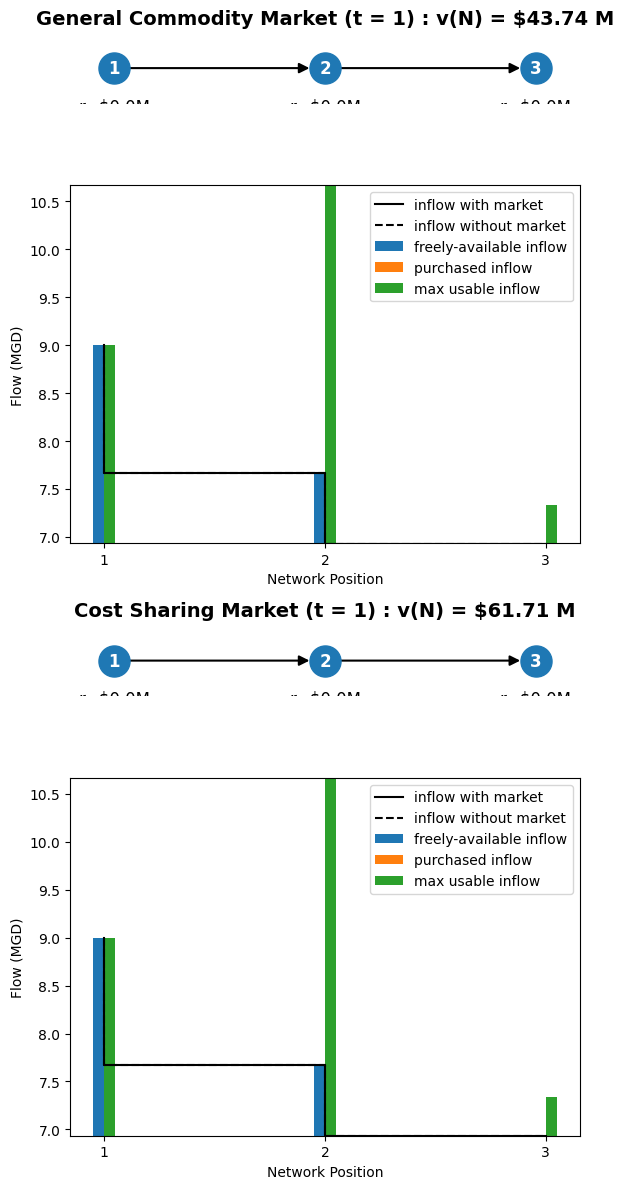

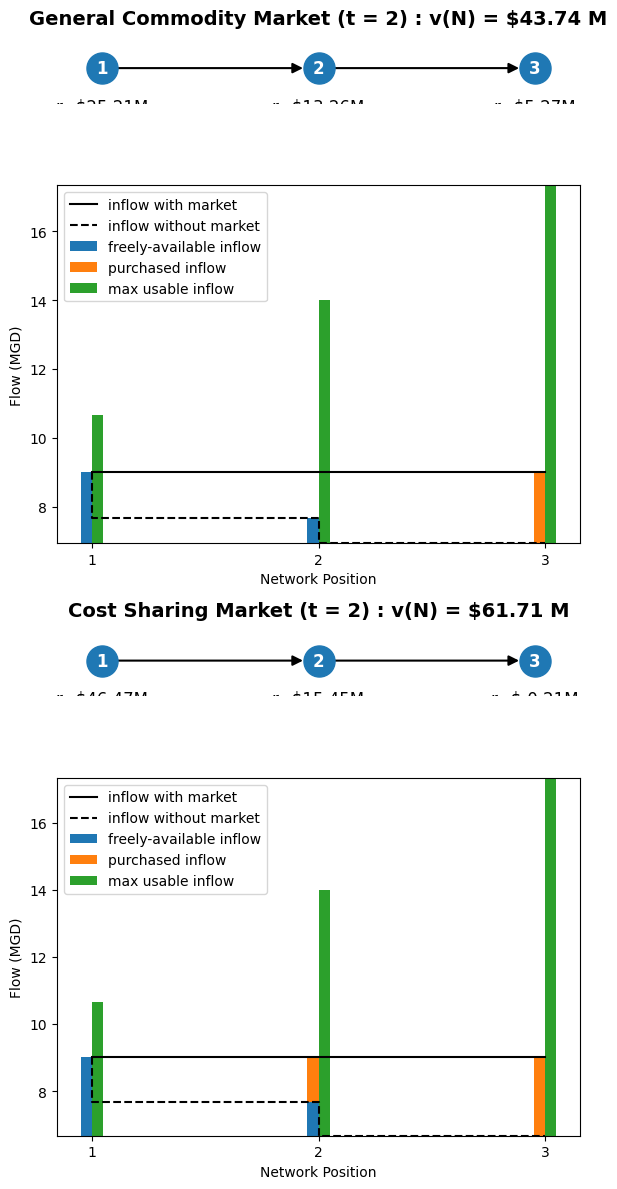

In [7]:
def avg(n1,n2):
    return 0.5*(n1+n2)

###Start figure Generation procedure
for t in ['1','2']:
    ##Define dictionaries
    pos = {}
    mapping = {}
    node_labels = {}
    node_label_pos = {}
    benefit_labels_gcm = {}
    benefit_labels_csm = {}
    benefit_label_pos = {}
    flow_label_pos = {}
    demand_t = {}
    net_inf_gcm_t = {}
    min_inf_gcm_t = {}
    min_inf_csm_t = {}
    min_dem_inf_gcm_t = {}
    min_dem_inf_csm_t = {}
    net_inf_csm_t = {}
    wp_gcm_t = {}
    wp_csm_t = {}

    ##Define graphical model
    dg = nx.DiGraph() #Build graphical model

    ##Populate network parameters, label positions, and label values
    for i, p in enumerate(players): 
        if i < len(players)-1:
            dg.add_edge(i, i+1) #Add edge to upstream neighbor
        pos[i] = (1*(i+1),0) #Assign position in the network
        mapping[i] = p #Create mapping between nx label and gams label
        node_label_pos[mapping[i]] = pos[i] #Position label names at the nodal positions
        node_labels[mapping[i]] = mapping[i] #Specify the node names themselves
        #Calculate reward values for both market types using the net benefit dictionaries
        gcm_rew_val = round(net_ben_gcm["net_benefit_gcm"+'%s' %str((p,t))]-net_ben_nm["net_benefit_nm"+'%s' %str((p,t))],2)
        csm_rew_val = round(net_ben_csm["net_benefit_csm"+'%s' %str((p,t))]-net_ben_nm["net_benefit_nm"+'%s' %str((p,t))],2)
        benefit_labels_gcm[p] = "r=$"+str(gcm_rew_val)+"M" #Get GCM benefit label values 
        benefit_labels_csm[p] = "r=$"+str(csm_rew_val)+"M" #Get CSM benefit label values
        benefit_label_pos[mapping[i]] = ((i+1),-0.1) #Place benefit labels under the node
        
        # Extract data from the relevant dictionaries for the current time period plot only
        demand_t[p] = demand[p,t]
        net_inf_gcm_t[p] = net_inf_gcm["net_inflow_gcm"+'%s' %str((p,t))]
        net_inf_csm_t[p] = net_inf_csm["net_inflow_csm"+'%s' %str((p,t))]
        min_inf_gcm_t[p] = min_inf_gcm["min_inflow_gcm"+'%s' %str((p,t))]
        min_inf_csm_t[p] = min_inf_csm["min_inflow_csm"+'%s' %str((p,t))]
        min_dem_inf_gcm_t[p] = min_dem_inf_gcm["min_dem_inf_gcm"+'%s' %str((p,t))]
        min_dem_inf_csm_t[p] = min_dem_inf_csm["min_dem_inf_csm"+'%s' %str((p,t))]
        wp_gcm_t[p] = wp["wp_sparse"+'%s' %str((p,t))]
        wp_csm_t[p] = csm_var_dict["WP_S"+'%s' %str((p,t))]

    nx.relabel.relabel_nodes(dg,mapping) #Relabel nodes from their defaults to reflect the actual names of the players

    pos_zip = list(zip(*pos.values())) #Get x coordinates from position tuples to facilitate subsequent plot creation
    pos_x = list(pos_zip[0])
    pos_x.sort()

    ##Global figure properties
    gs_kw = dict(width_ratios=[1], height_ratios=[1, 5, 1, 5]) #Specify desired aspect ratios between plan and profile views
    width = 0.05 #Specify desired width for bar graph plots
    locator = ticker.MultipleLocator(base=1) #Set ticks to only display the sequential position of each player
    
    ##Generate figure and axes objects to decorate
    fig, (axes1, axes2, axes3, axes4) = plt.subplots(4,1,gridspec_kw=gs_kw)
    

    ##Draw network plot and associated labels for the GCM market
    nx.draw_networkx_labels(dg, ax=axes1, labels = benefit_labels_gcm,pos=benefit_label_pos,verticalalignment = 'top')
    nx.draw_networkx_labels(dg, ax=axes1, labels = node_labels,pos=node_label_pos, font_color='w',font_weight='bold')
    nx.draw(dg, ax=axes1, with_labels = False, pos=pos, node_size=500, arrowsize=15,width=1.5)
    
    ##Draw profile plot for the GCM market
    #Generate line plots
    net_data_gcm = {}
    min_data_gcm = {}
    levels = ['high','low']
    for (i,p),l in itertools.product(enumerate(players),levels): #Generate step functions from inflow data
        if i < len(players)-1:
            if l == 'high':
                net_data_gcm[i+1,l] = net_inf_gcm_t[players[i]]
                min_data_gcm[i+1,l] = min_inf_gcm_t[players[i]]
            elif l == 'low':
                net_data_gcm[i+1,l] = net_inf_gcm_t[players[i+1]]
                min_data_gcm[i+1,l] = min_inf_gcm_t[players[i+1]]
        else:
            net_data_gcm[i+1,'high'] = net_inf_gcm_t[players[i]]
            min_data_gcm[i+1,'high'] = min_inf_gcm_t[players[i]]
    dict_key_list = list(net_data_gcm.keys())
    zip_x = list(zip(*dict_key_list))
    x = list(zip_x[0])
    y_net = list(net_data_gcm.values())
    y_min = list(min_data_gcm.values())
    net_plt_gcm = axes2.plot(x,y_net,color='black',label='inflow with market')
    min_plt_gcm = axes2.plot(x,y_min,color='black',linestyle='dashed',label='inflow without market')
    #Generate bar plots
    min_dem_inf_bar_gcm = axes2.bar(np.array(pos_x)-width/2,list(min_dem_inf_gcm_t.values()),width=width,label='freely-available inflow')
    wp_bar_gcm = axes2.bar(np.array(pos_x)-width/2,list(wp_gcm_t.values()),width=width,bottom=list(min_dem_inf_gcm_t.values()),label='purchased inflow')
    dem_bar_gcm = axes2.bar(np.array(pos_x)+width/2,np.array(list(demand_t.values()))+np.array(list(rfc.values())), width=width,label='max usable inflow')
    #Decorate axes
    axes2.set_xlabel("Network Position")
    axes2.set_ylabel("Flow (MGD)")
    axes2.set_ylim(min(min_dem_inf_gcm_t.values()),max(rfc.values())+max(demand_t.values()))
    axes2.xaxis.set_major_locator(locator)
    axes2.legend()

    
    ##Draw network plot and associated labels for the CSM market
    nx.draw_networkx_labels(dg, ax=axes3, labels = benefit_labels_csm,pos=benefit_label_pos,verticalalignment = 'top')
    nx.draw_networkx_labels(dg, ax=axes3, labels = node_labels,pos=node_label_pos, font_color='w',font_weight='bold')
    nx.draw(dg, ax=axes3, with_labels = False, pos=pos, node_size=500, arrowsize=15,width=1.5)

    ##Draw profile plot for the CSM market
    #Generate line plots
    net_data_csm = {}
    min_data_csm = {}
    levels = ['high','low']
    for (i,p),l in itertools.product(enumerate(players),levels): #Generate step functions from inflow data
        if i < len(players)-1:
            if l == 'high':
                net_data_csm[i+1,l] = net_inf_csm_t[players[i]]
                min_data_csm[i+1,l] = min_inf_csm_t[players[i]]
            elif l == 'low':
                net_data_csm[i+1,l] = net_inf_csm_t[players[i+1]]
                min_data_csm[i+1,l] = min_inf_csm_t[players[i+1]]
        else:
            net_data_csm[i+1,'high'] = net_inf_csm_t[players[i]]
            min_data_csm[i+1,'high'] = min_inf_csm_t[players[i]]
    dict_key_list = list(net_data_csm.keys())
    zip_x = list(zip(*dict_key_list))
    x = list(zip_x[0])
    y_net = list(net_data_csm.values())
    y_min = list(min_data_csm.values())    
    net_plt_csm = axes4.plot(x,y_net,color='black', label='inflow with market')
    min_plt_csm = axes4.plot(x,y_min,color='black',linestyle='dashed',label='inflow without market')
    #Generate bar plots
    min_dem_inf_bar_csm = axes4.bar(np.array(pos_x)-width/2,list(min_dem_inf_csm_t.values()),width=width,label='freely-available inflow')
    wp_bar_csm = axes4.bar(np.array(pos_x)-width/2,list(wp_csm_t.values()),width=width,bottom=list(min_dem_inf_csm_t.values()),label='purchased inflow')
    dem_bar_csm = axes4.bar(np.array(pos_x)+width/2,np.array(list(demand_t.values()))+np.array(list(rfc.values())), width=width,label='max usable inflow')
    #Decorate axes
    axes4.set_xlabel("Network Position")
    axes4.set_ylabel("Flow (MGD)")
    axes4.set_ylim(min(min_dem_inf_csm_t.values()),max(rfc.values())+max(demand_t.values()))
    axes4.xaxis.set_major_locator(locator)
    axes4.legend()
    fontdict = {'fontsize': 14, 'fontweight':'bold'}
    axes1.set_title("General Commodity Market (t = %s) :"%t+" v(N) = $%s M" %(round(tot_ben_gcm-tot_ben_nm,2)), fontdict = fontdict)
    axes3.set_title("Cost Sharing Market (t = %s) :"%t+" v(N) = $%s M" %(round(tot_ben_csm-tot_ben_nm,2)), fontdict = fontdict)

    fig.set_size_inches(6, 12)
    fig.tight_layout()
